In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import statsmodels.api as sm
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from scipy.stats import loguniform
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle 

In [2]:
df_1 = pd.read_csv('survey.csv')
pd.set_option('display.max_columns', 50)

df_1.head()

nrows_df1 = len(df_1)
print("Our original dataset has %2d rows." % nrows_df1)

Our original dataset has 1259 rows.


# Project Background



* **Timestamp**
* **Age**
* **Gender**
* **Country**
* **state**: If you live in the United States, which state or territory do you live in?
* **self_employed**: Are you self-employed?
* **family_history**: Do you have a family history of mental illness?
* **treatment**: Have you sought treatment for a mental health condition?
* **work_interfere**: If you have a mental health condition, do you feel that it interferes with your work?
* **no_employees**: How many employees does your company or organization have?
* **remote_work**: Do you work remotely (outside of an office) at least 50% of the time?
* **tech_company**: Is your employer primarily a tech company/organization?
* **benefits**: Does your employer provide mental health benefits?
* **care_options**: Do you know the options for mental health care your employer provides?
* **wellness_program**: Has your employer ever discussed mental health as part of an employee wellness program?
* **seek_help**: Does your employer provide resources to learn more about mental health issues and how to seek help?
* **anonymity**: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?
* **leave**: How easy is it for you to take medical leave for a mental health condition?
* **mentalhealthconsequence**: Do you think that discussing a mental health issue with your employer would have negative consequences?
* **physhealthconsequence**: Do you think that discussing a physical health issue with your employer would have negative consequences?
* **coworkers**: Would you be willing to discuss a mental health issue with your coworkers?
* **physhealthinterview**: Would you bring up a physical health issue with a potential employer in an interview?
* **mentalvsphysical**: Do you feel that your employer takes mental health as seriously as physical health?
* **obs_consequence**: Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?
* **comments**: Any additional notes or comments

# Data Cleaning

For this section of the data science project, we will conduct necessary data preprocessing and cleaning based on the concerns we had pointed out from EDA. This includes: 
1. Removing NaN values
2. Removing values that don't make sense
3. Outlier Analysis and Handling

In [3]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [4]:
df_1['treatment'].value_counts()

Yes    637
No     622
Name: treatment, dtype: int64

In [5]:
profile = ProfileReport(df_1, minimal=True)

In [6]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Age Column

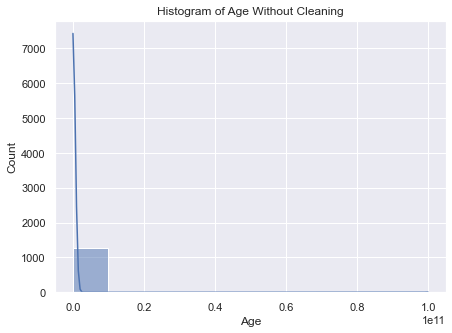

In [7]:
plt.figure(figsize = (7,5))
sns.set(style="darkgrid")
plt.title('Histogram of Age Without Cleaning')
sns.histplot(data=df_1, x="Age", kde=True, bins=10)

We see that are bad data in this column that affected the distribution. There are very large and small values that make no sense. We will remove these age values where age is negative and the value where age is >150 and <18. Then, we will then look at the new distribution of data.

In [8]:
df_1 = df_1.drop(df_1[(df_1.Age < 0) | (df_1.Age > 150) | (df_1.Age < 18)].index)

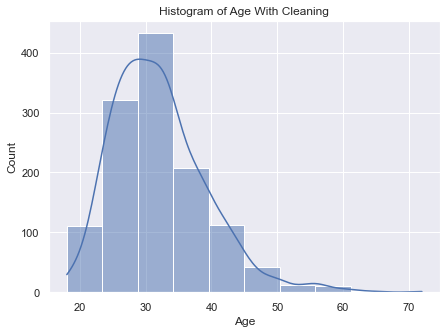

In [9]:
plt.figure(figsize = (7,5))
plt.title('Histogram of Age With Cleaning')
sns.histplot(data=df_1, x="Age", kde=True, bins=10)

Most of the age is distributed around mid 20's to mid 30's. 

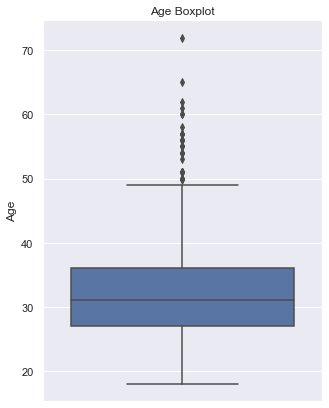

In [10]:
plt.figure(figsize = (5,7))
plt.title('Age Boxplot')
sns.boxplot(y=df_1['Age'])

We define outliers as those data points that are outside Q3+IQR. We see that there are a lot of outliers in this area. How much though? 

In [11]:
age_25p, age_75p = df_1['Age'].quantile([.25, .75])
age_limit_over = age_75p+((age_75p-age_25p)*1.5)
age_limit_under = age_25p-((age_75p-age_25p)*1.5)
overlimit_age = df_1[df_1['Age'] > age_limit_over]
underlimit_age = df_1[df_1['Age'] < age_limit_under]
len(overlimit_age)
print("The upper outlier range for age is {}. There are {} people in this range.".
      format(age_limit_over,len(overlimit_age)))

The upper outlier range for age is 49.5. There are 32 people in this range.


Because age will be our only numeric dataset while all others is categorical, we will also group ages into bins and add this as another column. We will evaluate later in our analysis if this would be beneficial or not.

In [12]:
df_1['Age_range'] = pd.cut(df_1['Age'], [0,20,30,50,100], 
                           labels=["0-20", "21-30", "31-50", "51-100"], include_lowest=True)

In [13]:
df_1['Age_range'].value_counts()

31-50     646
21-30     557
51-100     26
0-20       22
Name: Age_range, dtype: int64

# Gender

Gender has a lot of unique values. Though this column is predominantly split between male and female, there are minor syntax differences that make it a unique value from the actual value it should represent. There are also many other values that fit under the umbrella of transgender. The 3 gender categories we will represent in our analysis is female, male, and transgender

In [14]:
#clean texte
df_1['Gender']=df_1['Gender'].str.strip()
df_1['Gender']=df_1['Gender'].str.lower()

In [15]:
df_1['Gender'].unique()

array(['female', 'm', 'male', 'male-ish', 'maile', 'trans-female',
       'cis female', 'f', 'something kinda male?', 'cis male', 'woman',
       'mal', 'male (cis)', 'queer/she/they', 'non-binary', 'femake',
       'make', 'nah', 'enby', 'fluid', 'genderqueer', 'androgyne',
       'agender', 'cis-female/femme', 'guy (-ish) ^_^',
       'male leaning androgynous', 'man', 'trans woman', 'msle', 'neuter',
       'female (trans)', 'queer', 'female (cis)', 'mail', 'malr',
       'femail', 'cis man',
       'ostensibly male, unsure what that really means'], dtype=object)

In [16]:
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", 
            "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", 
              "female (cis)", "femail"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", 
             "non-binary","nah", "all", "enby", "fluid", "genderqueer", 
             "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", 
             "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"] 

keep_genders = male_str + female_str + trans_str
df_1 = df_1[df_1['Gender'].isin(keep_genders)]

In [17]:
#replace all different values for male, female into the same respective category
for row,col in df_1.iterrows():
    if str.lower(col.Gender) in male_str:
        df_1['Gender'].replace(to_replace=col.Gender,value='male', inplace=True)  
    if str.lower(col.Gender) in female_str:
        df_1['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)
    if str.lower(col.Gender) in trans_str:
        df_1['Gender'].replace(to_replace=col.Gender, value='transgender', inplace=True)

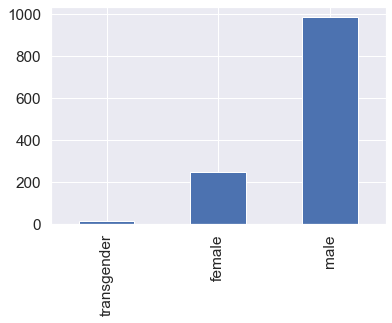

In [18]:
sns.set(font_scale=1.4)
df_1['Gender'].value_counts().sort_values().plot(kind='bar');

We notice that there is a misrepresentation of gender. We must keep this in mind when making conclusions we gather from the data insights later in our analysis and interpretation. However, this may also serve to be an interesting opportunity to generate segmented insights between the three genders.

## Unnecessary Columns
We will drop the following columns for specific reasons:
1. **Comments**: is an irrelevant predictor for our analysis since NLP is out of scope for this use case. 87% of the records are missing, so it will be best to remove this column
2. **Country**: 59.7% of the records belong to the United States. If we wanted to focus our analysis on mental health in the United States, we would be filtering out a little less than half of our data. Since we will be conducting machine learning, we want to have as much data as we can for training. Instead of looking at mental health within the cultural/political dependencies of the United States, we will rather use this analysis for mental health as a global issue. 
3. **State**: Since the geographic factor of country is removed, we will do the same with state.
4. **Timestamp**: The time and date a respondent took the survey is irrelevant for our analysis.

In [19]:
df_1.drop(['Timestamp','comments', 'Country', 'state'], axis=1, inplace=True)

## Missing Values

The rest of the columns in the dataset are survey questions and responses. Since there are no issues with these categorical variables, we will continue with addressing NaN values. We will address how we will handle missing values for the two column where they exist.
* **self_employed**: Since there are only a few missing records for this column, we will simply drop these records.
* **work_intefere**: Because we are dealing with a relatively smaller dataset, removing Nan records wouldn't be practical. We need to preserve our data. We also found that these missing records have our dependent variable with the target class. So, removing our target class may negatively harm our modeling. Instead of removing the records, we will create a new class for this predictor.

In [20]:
df_1.isna().sum()

Age                            0
Gender                         0
self_employed                 18
family_history                 0
treatment                      0
work_interfere               262
no_employees                   0
remote_work                    0
tech_company                   0
benefits                       0
care_options                   0
wellness_program               0
seek_help                      0
anonymity                      0
leave                          0
mental_health_consequence      0
phys_health_consequence        0
coworkers                      0
supervisor                     0
mental_health_interview        0
phys_health_interview          0
mental_vs_physical             0
obs_consequence                0
Age_range                      0
dtype: int64

In [21]:
df_1['work_interfere'] = df_1['work_interfere'].fillna('Do Not Know')

In [22]:
df_1 = df_1.dropna()

In [23]:
clean_df = df_1.copy()
nrows_cleandf = len(clean_df)
print("Our new dataframe has %2d rows." % nrows_cleandf)

Our new dataframe has 1233 rows.


## Handling Text and Categorical Attributes

Since most of our dataset consits of categorical variables, we will need to Numerically represent their values. We will utilize both one-hot encoding and label encoding. 
* We apply **One-Hot Encoding** when:
    * The categorical feature is not ordinal 
* We apply **Label Encoding** when:
    * The categorical feature is ordinal 

### One-Hot Encoding

In [24]:
categorical_var=clean_df.select_dtypes(include=['object', 'category']).columns
non_ordinal_cols=[column_name for column_name in categorical_var if 'Yes' in clean_df[column_name].values]
non_ordinal_cols.append('Gender')

In [25]:
non_ordinal_cols

['self_employed',
 'family_history',
 'treatment',
 'remote_work',
 'tech_company',
 'benefits',
 'care_options',
 'wellness_program',
 'seek_help',
 'anonymity',
 'mental_health_consequence',
 'phys_health_consequence',
 'coworkers',
 'supervisor',
 'mental_health_interview',
 'phys_health_interview',
 'mental_vs_physical',
 'obs_consequence',
 'Gender']

In [26]:
final_df = pd.get_dummies(clean_df, columns=non_ordinal_cols, drop_first=True)

In [27]:
final_df.columns

Index(['Age', 'work_interfere', 'no_employees', 'leave', 'Age_range',
       'self_employed_Yes', 'family_history_Yes', 'treatment_Yes',
       'remote_work_Yes', 'tech_company_Yes', 'benefits_No', 'benefits_Yes',
       'care_options_Not sure', 'care_options_Yes', 'wellness_program_No',
       'wellness_program_Yes', 'seek_help_No', 'seek_help_Yes', 'anonymity_No',
       'anonymity_Yes', 'mental_health_consequence_No',
       'mental_health_consequence_Yes', 'phys_health_consequence_No',
       'phys_health_consequence_Yes', 'coworkers_Some of them',
       'coworkers_Yes', 'supervisor_Some of them', 'supervisor_Yes',
       'mental_health_interview_No', 'mental_health_interview_Yes',
       'phys_health_interview_No', 'phys_health_interview_Yes',
       'mental_vs_physical_No', 'mental_vs_physical_Yes',
       'obs_consequence_Yes', 'Gender_male', 'Gender_transgender'],
      dtype='object')

### Label Encoding

In [28]:
ordinal_cols=[var for var in categorical_var if var not in non_ordinal_cols]
print(ordinal_cols)
final_df.loc[:, ordinal_cols]

['work_interfere', 'no_employees', 'leave', 'Age_range']


work_interfere    no_employees               leave Age_range
18        Sometimes             1-5           Very easy     31-50
19      Do Not Know            6-25       Somewhat easy     31-50
20        Sometimes         100-500  Somewhat difficult     21-30
21            Never             1-5  Somewhat difficult     31-50
22            Often          26-100          Don't know     31-50
...             ...             ...                 ...       ...
1254    Do Not Know          26-100       Somewhat easy     21-30
1255          Often          26-100  Somewhat difficult     31-50
1256      Sometimes  More than 1000  Somewhat difficult     31-50
1257    Do Not Know         100-500          Don't know     31-50
1258      Sometimes          26-100          Don't know     21-30

[1233 rows x 4 columns]

In [29]:
final_df.loc[:, ordinal_cols]

work_interfere    no_employees               leave Age_range
18        Sometimes             1-5           Very easy     31-50
19      Do Not Know            6-25       Somewhat easy     31-50
20        Sometimes         100-500  Somewhat difficult     21-30
21            Never             1-5  Somewhat difficult     31-50
22            Often          26-100          Don't know     31-50
...             ...             ...                 ...       ...
1254    Do Not Know          26-100       Somewhat easy     21-30
1255          Often          26-100  Somewhat difficult     31-50
1256      Sometimes  More than 1000  Somewhat difficult     31-50
1257    Do Not Know         100-500          Don't know     31-50
1258      Sometimes          26-100          Don't know     21-30

[1233 rows x 4 columns]

In [30]:
final_df['Age_range'].value_counts()

31-50     633
21-30     552
51-100     26
0-20       22
Name: Age_range, dtype: int64

In [31]:
def replace_labels(value_map, column_name, dataframe):
    
    dataframe=dataframe.replace({column_name:value_map})
    return(dataframe)

to_replace_workInterfere = {'Do Not Know': 0,'Never': 1, 'Rarely': 2, 'Sometimes':3, 'Often':4}
to_replace_noEmployees = {'1-5': 0, '6-25': 1, '26-100':2, '100-500':3, '500-1000':4, 'More than 1000':5}
to_replace_leave = {"Don't know": 0, 'Very difficult': 1, 'Somewhat difficult':2, 
                          'Somewhat easy':3, 'Very easy':4}
to_replace_ageRange= {'0-20': 0, '21-30': 1, '31-50':2, '51-100':3}

In [32]:
final_df=replace_labels(to_replace_workInterfere, 'work_interfere', final_df)
final_df=replace_labels(to_replace_noEmployees, 'no_employees', final_df)
final_df=replace_labels(to_replace_leave, 'leave', final_df)
final_df=replace_labels(to_replace_ageRange, 'Age_range', final_df)

In [33]:
#saving data
with open ('clean_df.pickle','wb') as f:#wb, write-byte
    pickle.dump (clean_df,f)
    
with open ('final_df.pickle','wb') as f:#wb, write-byte
    pickle.dump (final_df,f)

# Exploratory Data Analysis

First, we'll analyze how many respondents have sought treatment for mental health

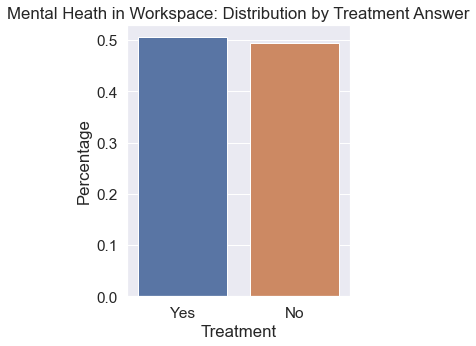

In [34]:
treatment_ans = clean_df['treatment'].value_counts(normalize = True).rename_axis('Treatment').reset_index(name = 'Percentage')
plt.figure(figsize = (4,5))
plt.title('Mental Heath in Workspace: Distribution by Treatment Answer')
sns.barplot(x = 'Treatment', y = 'Percentage', data = treatment_ans)

It can be observed that more than 50% of the respondents have recieved treatment for mental health, which is good to know because getting mental illness treated and managed leads to improved quality life.

Text(0, 0.5, 'Treatment')

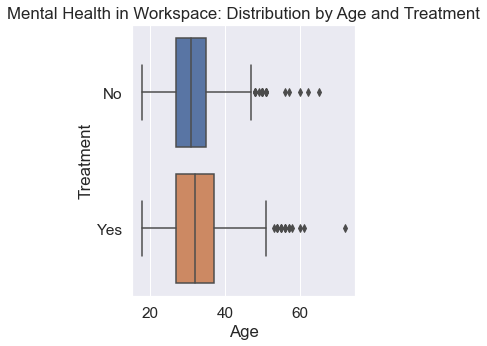

In [35]:
#Treatment analysis based on Age
plt.figure(figsize = (4,5))
plt.title('Mental Health in Workspace: Distribution by Age and Treatment')
sns.boxplot(x = clean_df['Age'], y = clean_df['treatment'])
plt.xlabel('Age')
plt.ylabel('Treatment')

It can be observed that there is no significant difference of ages between respondents that seek treatment and those that do no seek treatment.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


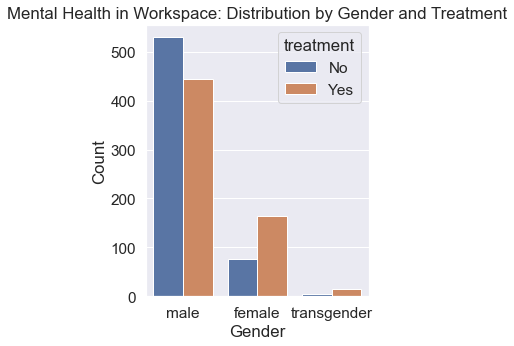

In [36]:
#Treatment analysis based on gender
plt.figure(figsize = (4,5))
sns.countplot(clean_df['Gender'], hue = clean_df['treatment'])
plt.title('Mental Health in Workspace: Distribution by Gender and Treatment')
plt.ylabel('Count')
plt.show()

In [37]:
#Treatment analysis based on age and gender
import plotly.express as px
fig = px.violin(clean_df, y = 'Age', x = 'treatment', color = 'Gender', box = True, points = 'all')
fig.update_layout(title = 'Mental Health in Workspace: Distribution by Age, Gender and Treatment', xaxis_title='Treatment')

It can be observed from the visualization that out of the respondents who sought treatment, median age of male is higher than the median age of females. 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



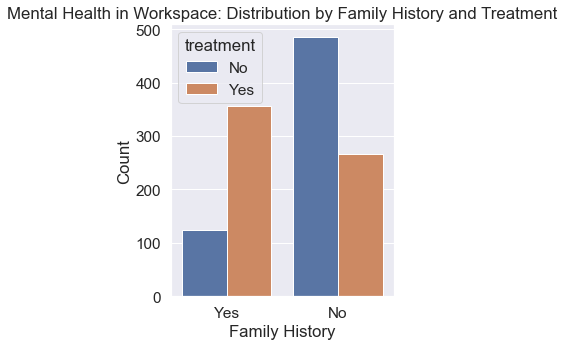

In [38]:
#Treatment analysis based on family history
plt.figure(figsize = (4,5))
sns.countplot(clean_df['family_history'], hue = clean_df['treatment'])
plt.title('Mental Health in Workspace: Distribution by Family History and Treatment')
plt.xlabel('Family History')
plt.ylabel('Count')
plt.show()

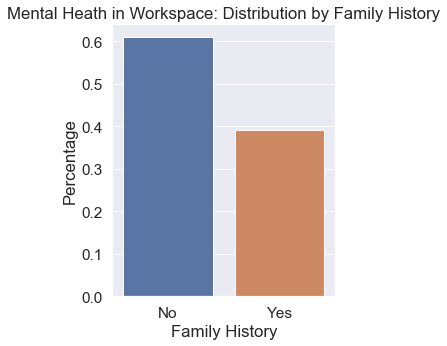

In [39]:
fh_ans = clean_df['family_history'].value_counts(normalize = True).rename_axis('Family History').reset_index(name = 'Percentage')
plt.figure(figsize = (4,5))
plt.title('Mental Heath in Workspace: Distribution by Family History')
sns.barplot(x = 'Family History', y = 'Percentage', data = fh_ans)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



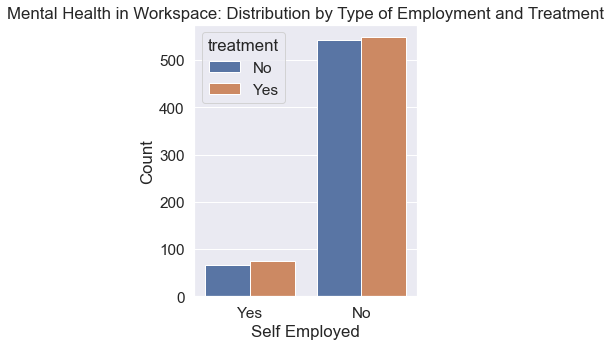

In [40]:
#Treatment analysis based on employment
plt.figure(figsize = (4,5))
sns.countplot(clean_df['self_employed'], hue = clean_df['treatment'])
plt.title('Mental Health in Workspace: Distribution by Type of Employment and Treatment')
plt.xlabel('Self Employed')
plt.ylabel('Count')
plt.show()

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

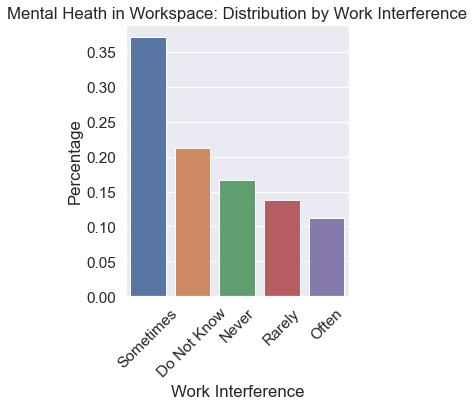

In [41]:
wkifr_ans = clean_df['work_interfere'].value_counts(normalize = True).rename_axis('Work Interference').reset_index(name = 'Percentage')
plt.figure(figsize = (4,5))
plt.title('Mental Heath in Workspace: Distribution by Work Interference')
sns.barplot(x = 'Work Interference', y = 'Percentage', data = wkifr_ans)
plt.xticks(rotation = 45)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

<ipython-input-42-91aeb0ff2d75>:9: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



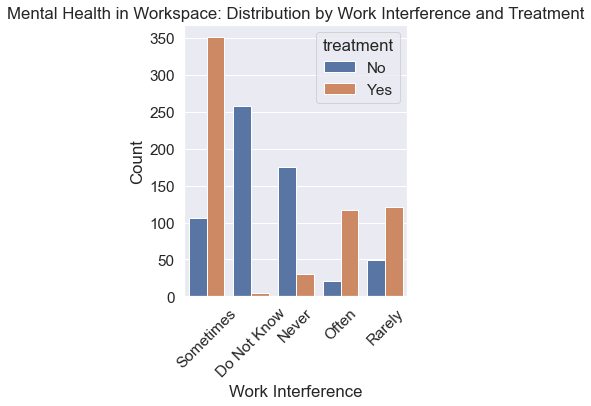

In [42]:
#Treatment analysis based on work intereferance
plt.figure(figsize = (4,5))
sns.countplot(clean_df['work_interfere'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Work Interference and Treatment')

plt.xlabel('Work Interference')
plt.ylabel('Count')
plt.tight_layout()
plt.xticks(rotation = 45)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

<ipython-input-43-01f8781598cf>:9: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



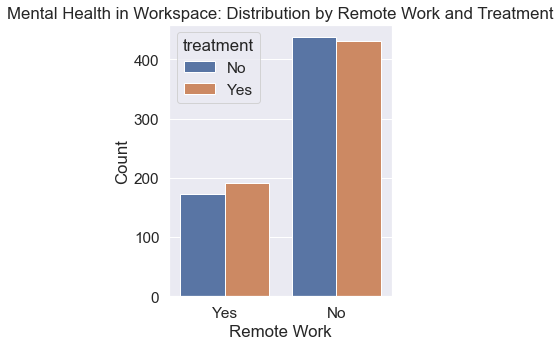

In [43]:
#Treatment analysis based on remote work
plt.figure(figsize = (4,5))
sns.countplot(clean_df['remote_work'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Remote Work and Treatment')

plt.xlabel('Remote Work')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

<ipython-input-44-c59bc9797c3a>:9: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



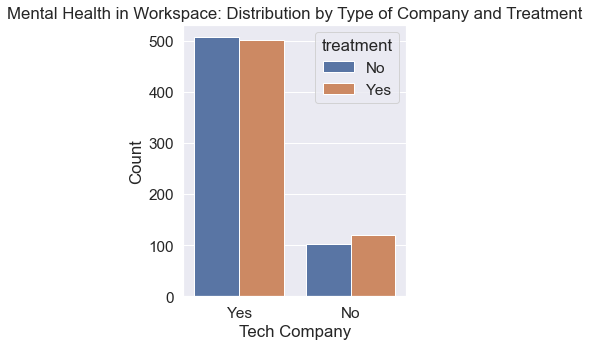

In [44]:
#Treatment analysis based on type of company
plt.figure(figsize = (4,5))
sns.countplot(clean_df['tech_company'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Type of Company and Treatment')

plt.xlabel('Tech Company')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



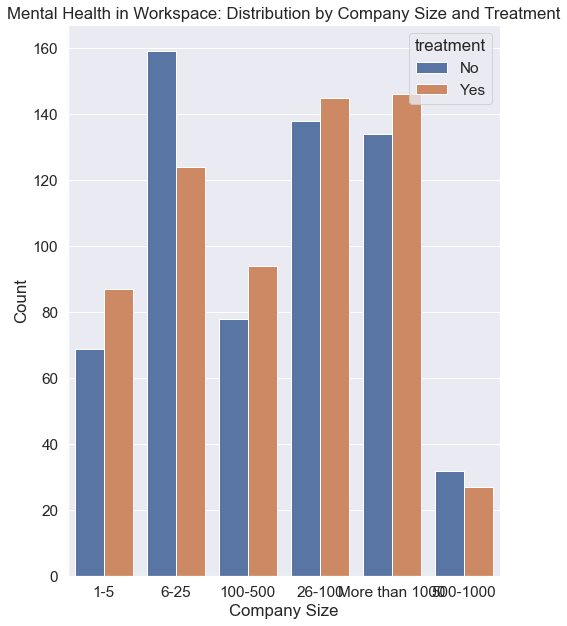

In [45]:
plt.figure(figsize = (8,9))
sns.countplot(clean_df['no_employees'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Company Size and Treatment')

plt.xlabel('Company Size')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

No significant correlation between working style (self-employed, remote work, tech company) and company size.

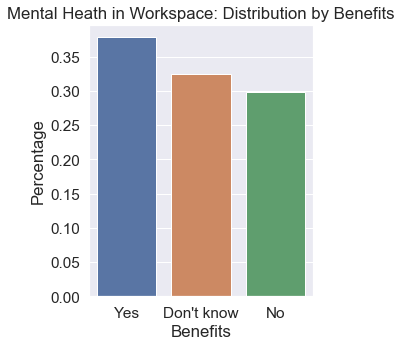

In [46]:
#Analyzing Mental Health Supporting Data
#Analysis by Benefits

benefit_ans = clean_df['benefits'].value_counts(normalize = True).rename_axis('Benefits').reset_index(name = 'Percentage')
plt.figure(figsize = (4,5))
plt.title('Mental Heath in Workspace: Distribution by Benefits')
sns.barplot(x = 'Benefits', y = 'Percentage', data = benefit_ans)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



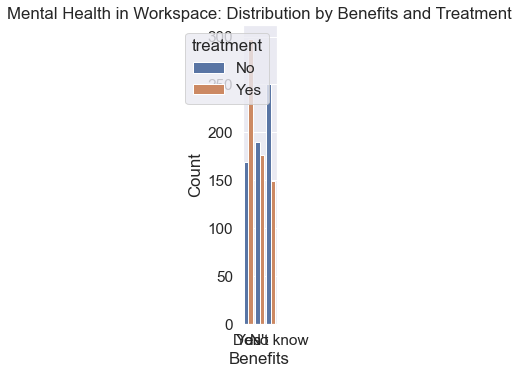

In [47]:
#Analysis by Benefits and Treatment Answer
plt.figure(figsize = (4.5,5.5))
sns.countplot(clean_df['benefits'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Benefits and Treatment')

plt.xlabel('Benefits')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

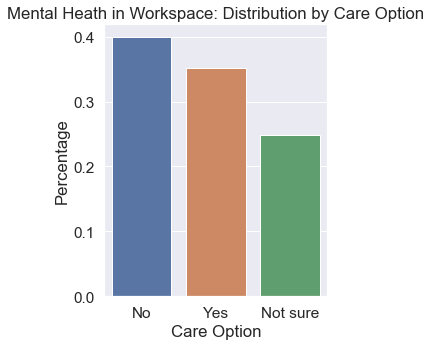

In [48]:
#Analysis by Care Option

care_options_ans = clean_df['care_options'].value_counts(normalize = True).rename_axis('Care Option').reset_index(name = 'Percentage')
plt.figure(figsize = (4,5))
plt.title('Mental Heath in Workspace: Distribution by Care Option')
sns.barplot(x = 'Care Option', y = 'Percentage', data = care_options_ans)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



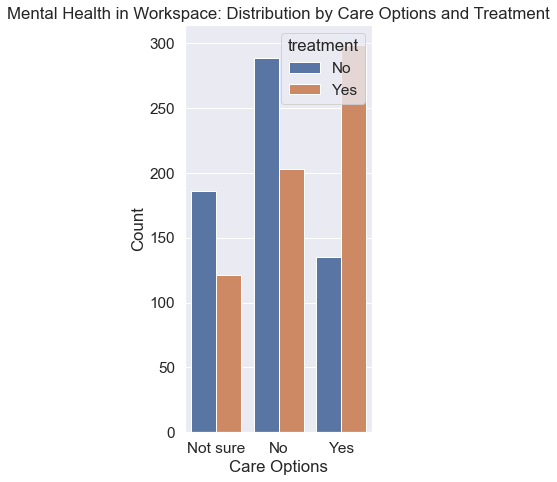

In [49]:
#Analysis by Care Option and Treatment Answer
plt.figure(figsize = (6,7))
sns.countplot(clean_df['care_options'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Care Options and Treatment')

plt.xlabel('Care Options')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

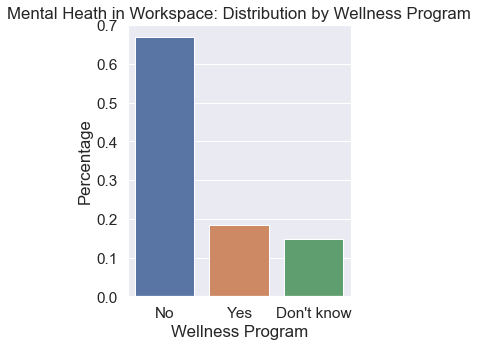

In [50]:
#Analysis by Wellness_program

wellness_program_ans = clean_df['wellness_program'].value_counts(normalize = True).rename_axis('Wellness Program').reset_index(name = 'Percentage')
plt.figure(figsize = (4,5))
plt.title('Mental Heath in Workspace: Distribution by Wellness Program')
sns.barplot(x = 'Wellness Program', y = 'Percentage', data = wellness_program_ans)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



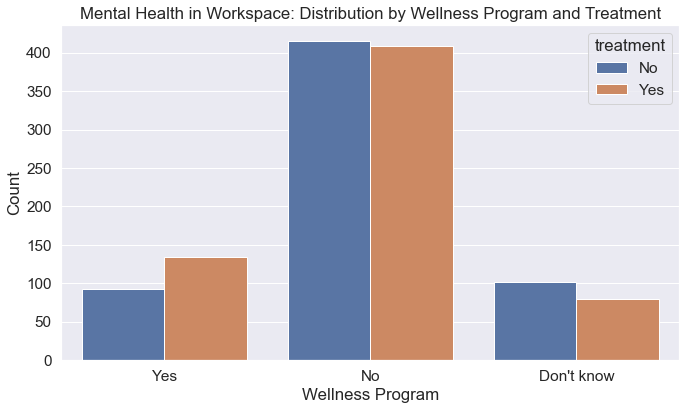

In [51]:
#Analysis by Wellness Program and Treatment Answer
plt.figure(figsize = (10,6))
sns.countplot(clean_df['wellness_program'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Wellness Program and Treatment')

plt.xlabel('Wellness Program')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

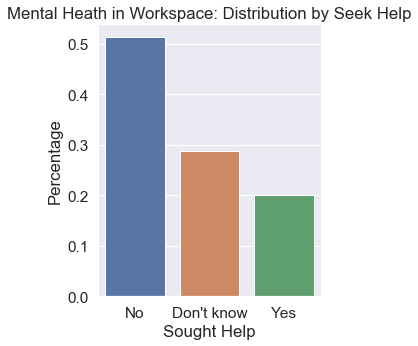

In [52]:
#Analysis whether they sought help or not

seek_help_ans = clean_df['seek_help'].value_counts(normalize = True).rename_axis('Sought Help').reset_index(name = 'Percentage')
plt.figure(figsize = (4,5))
plt.title('Mental Heath in Workspace: Distribution by Seek Help')
sns.barplot(x = 'Sought Help', y = 'Percentage', data = seek_help_ans)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



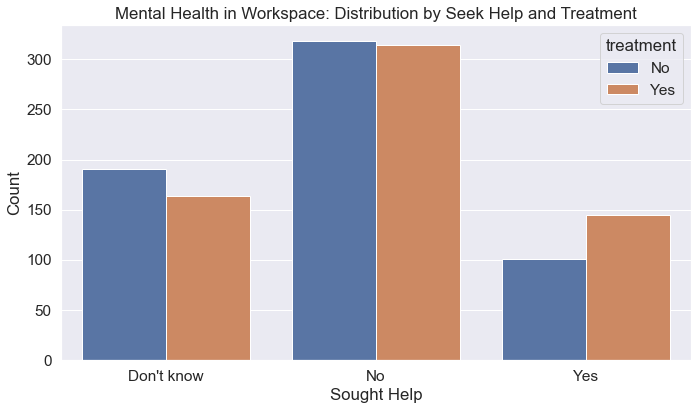

In [53]:
#Analysis by Seek_Help and Treatment Answer
plt.figure(figsize = (10,6))
sns.countplot(clean_df['seek_help'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Seek Help and Treatment')

plt.xlabel('Sought Help')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

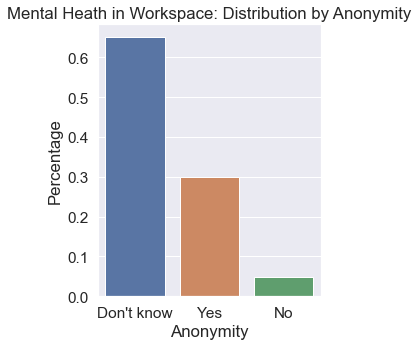

In [54]:
#Analysis by Anonymity

seek_help_ans = clean_df['anonymity'].value_counts(normalize = True).rename_axis('Anonymity').reset_index(name = 'Percentage')
plt.figure(figsize = (4,5))
plt.title('Mental Heath in Workspace: Distribution by Anonymity')
sns.barplot(x = 'Anonymity', y = 'Percentage', data = seek_help_ans)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



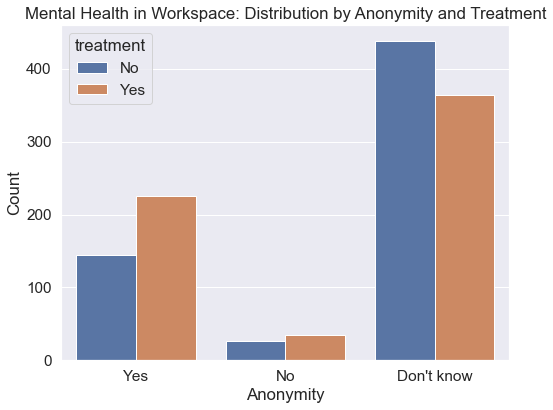

In [55]:
#Analysis by Anonymity and Treatment

plt.figure(figsize = (8,6))
sns.countplot(clean_df['anonymity'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Anonymity and Treatment')

plt.xlabel('Anonymity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

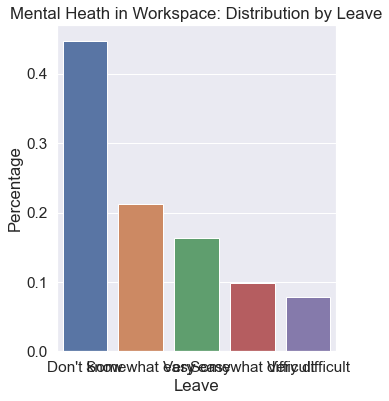

In [56]:
#Analysis by Leave
leave_ans = clean_df['leave'].value_counts(normalize = True).rename_axis('Leave').reset_index(name = 'Percentage')
plt.figure(figsize = (5,6))
plt.title('Mental Heath in Workspace: Distribution by Leave')
sns.barplot(x = 'Leave', y = 'Percentage', data = leave_ans)
#need to fix labels

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



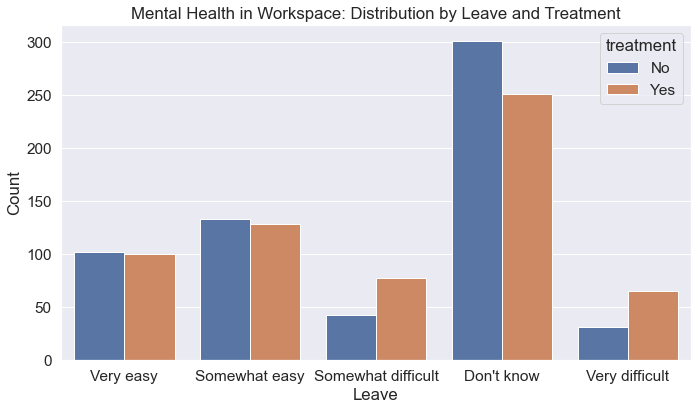

In [57]:
#Analysis by Leave and Treatment

plt.figure(figsize = (10,6))
sns.countplot(clean_df['leave'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Leave and Treatment')

plt.xlabel('Leave')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
#need to adjust the labels

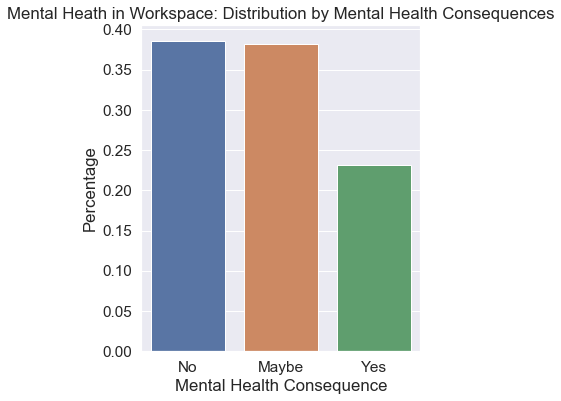

In [58]:
#Analysis by Mental Health Consequence
mh_consq_ans = clean_df['mental_health_consequence'].value_counts(normalize = True).rename_axis('Mental Health Consequence').reset_index(name = 'Percentage')
plt.figure(figsize = (5,6))
plt.title('Mental Heath in Workspace: Distribution by Mental Health Consequences')
sns.barplot(x = 'Mental Health Consequence', y = 'Percentage', data = mh_consq_ans)
#need to fix labels

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



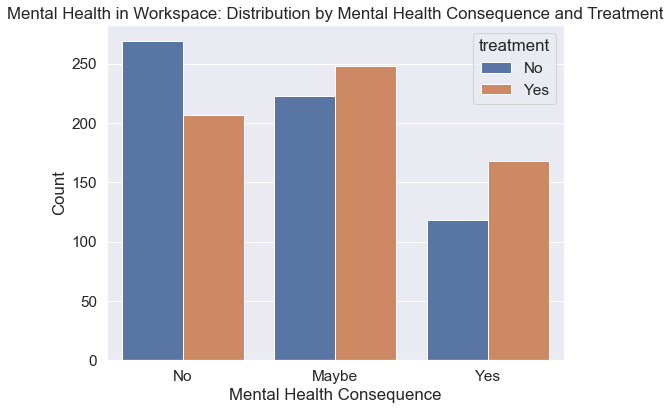

In [59]:
#Analysis by Mental Health Consequence and Treatment
plt.figure(figsize = (9,6))
sns.countplot(clean_df['mental_health_consequence'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Mental Health Consequence and Treatment')

plt.xlabel('Mental Health Consequence')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

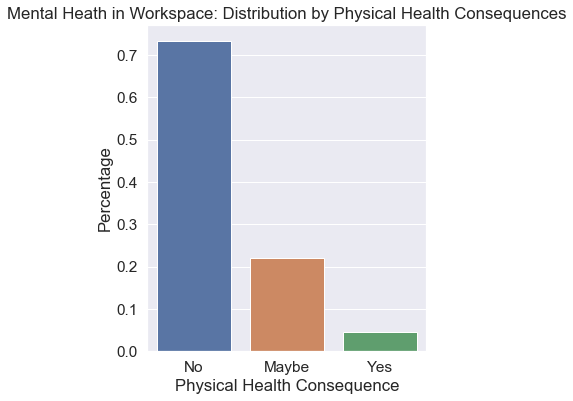

In [60]:
#Analysis by Physical Health Consequences

ph_consq_ans = clean_df['phys_health_consequence'].value_counts(normalize = True).rename_axis('Physical Health Consequence').reset_index(name = 'Percentage')
plt.figure(figsize = (5,6))
plt.title('Mental Heath in Workspace: Distribution by Physical Health Consequences')
sns.barplot(x = 'Physical Health Consequence', y = 'Percentage', data = ph_consq_ans)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

<ipython-input-61-220faa32a1a2>:9: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



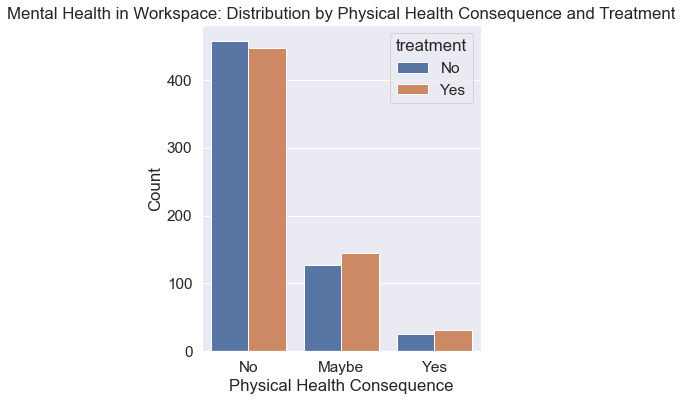

In [61]:
#Analysis by Physical Health Consequence and Treatment
plt.figure(figsize = (5,6))
sns.countplot(clean_df['phys_health_consequence'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Physical Health Consequence and Treatment')

plt.xlabel('Physical Health Consequence')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

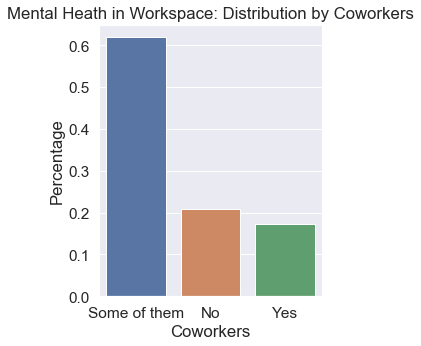

In [62]:
#Analysis by coworkers

coworkers_ans = clean_df['coworkers'].value_counts(normalize = True).rename_axis('Coworkers').reset_index(name = 'Percentage')
plt.figure(figsize = (4,5))
plt.title('Mental Heath in Workspace: Distribution by Coworkers')
sns.barplot(x = 'Coworkers', y = 'Percentage', data = coworkers_ans)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



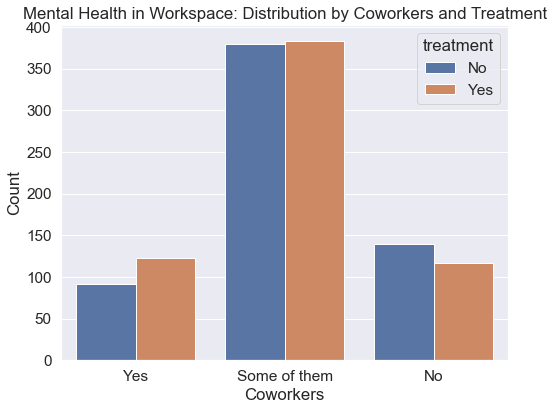

In [63]:
#Analysis by Coworkers and Treatment
plt.figure(figsize = (8,6))
sns.countplot(clean_df['coworkers'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Coworkers and Treatment')

plt.xlabel('Coworkers')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

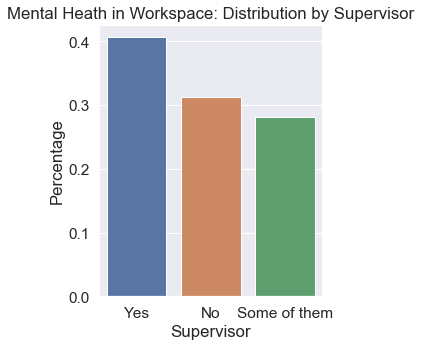

In [64]:
#Analysis by supervisor

supervisor_ans = clean_df['supervisor'].value_counts(normalize = True).rename_axis('Supervisor').reset_index(name = 'Percentage')
plt.figure(figsize = (4,5))
plt.title('Mental Heath in Workspace: Distribution by Supervisor')
sns.barplot(x = 'Supervisor', y = 'Percentage', data = supervisor_ans)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



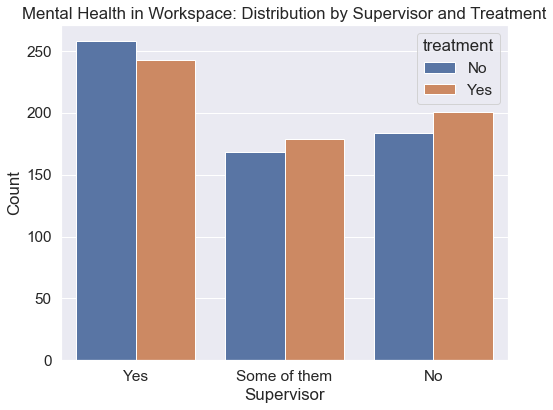

In [65]:
#Analysis by Supervisor and Treatment Answer
plt.figure(figsize = (8,6))
sns.countplot(clean_df['supervisor'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Supervisor and Treatment')

plt.xlabel('Supervisor')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

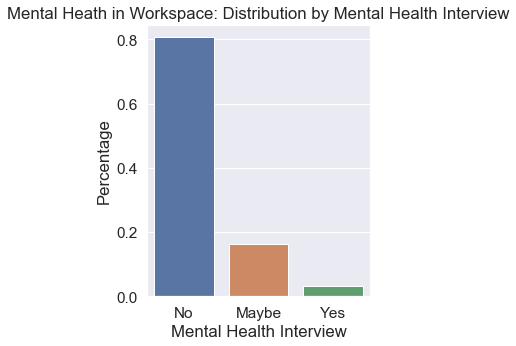

In [66]:
#Analysis by mental health interview

mh_intv_ans = clean_df['mental_health_interview'].value_counts(normalize = True).rename_axis('Mental Health Interview').reset_index(name = 'Percentage')
plt.figure(figsize = (4,5))
plt.title('Mental Heath in Workspace: Distribution by Mental Health Interview')
sns.barplot(x = 'Mental Health Interview', y = 'Percentage', data = mh_intv_ans)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

<ipython-input-67-5c222a275055>:9: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



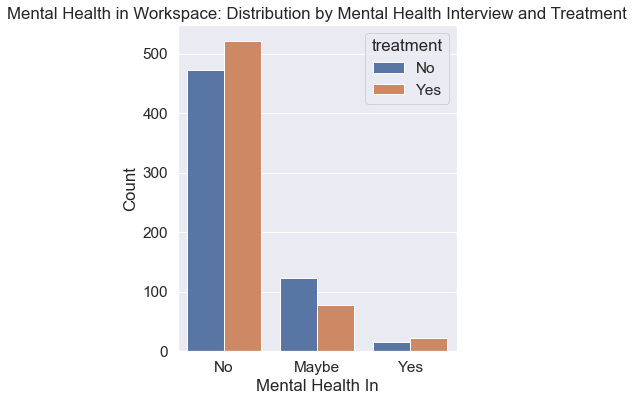

In [67]:
#Analysis by Mental Health Interview and Treatment Answer
plt.figure(figsize = (5,6))
sns.countplot(clean_df['mental_health_interview'], hue = clean_df['treatment'])

plt.title('Mental Health in Workspace: Distribution by Mental Health Interview and Treatment')

plt.xlabel('Mental Health In')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [68]:
with open ('final_df.pickle','rb') as f:#rb, read-byte
    df=pickle.load(f)

df=df.drop('Age', axis=1)

In [69]:
df.head()

work_interfere  no_employees  leave  Age_range  self_employed_Yes  \
18               3             0      4          2                  1   
19               0             1      3          2                  1   
20               3             3      2          1                  0   
21               1             0      2          2                  1   
22               4             2      0          2                  0   

    family_history_Yes  treatment_Yes  remote_work_Yes  tech_company_Yes  \
18                   1              0                1                 1   
19                   1              0                1                 1   
20                   1              1                0                 1   
21                   0              0                1                 1   
22                   0              1                1                 1   

    benefits_No  benefits_Yes  care_options_Not sure  care_options_Yes  \
18            0             1                      1                 0   
19            1             0                      0                 0   
20            0             1                      0                 1   
21            1             0                      0                 0   
22            0             1                      0                 1   

    wellness_program_No  wellness_program_Yes  seek_help_No  seek_help_Yes  \
18                    0                     1             0              0   
19                    0                     1             1              0   
20                    1                     0             1              0   
21                    1                     0             1              0   
22                    1                     0             1              0   

    anonymity_No  anonymity_Yes  mental_health_consequence_No  \
18             0              1                             1   
19             0              1                             1   
20             1              0                             0   
21             0              1                             1   
22             0              0                             0   

    mental_health_consequence_Yes  phys_health_consequence_No  \
18                              0                           1   
19                              0                           1   
20                              0                           1   
21                              0                           1   
22                              0                           1   

    phys_health_consequence_Yes  coworkers_Some of them  coworkers_Yes  \
18                            0                       0              1   
19                            0                       1              0   
20                            0                       1              0   
21                            0                       1              0   
22                            0                       1              0   

    supervisor_Some of them  supervisor_Yes  mental_health_interview_No  \
18                        0               1                           1   
19                        1               0                           0   
20                        1               0                           1   
21                        1               0                           1   
22                        0               1                           1   

    mental_health_interview_Yes  phys_health_interview_No  \
18                            0                         0   
19                            0                         0   
20                            0                         1   
21                            0                         0   
22                            0                         0   

    phys_health_interview_Yes  mental_vs_physical_No  mental_vs_physical_Yes  \
18                          1                      0                 

# Modeling

Our dependent, or target variable, for our analysis is treatment. This survey question asks, **have you sought treatment for a mental health condition?** Our approach for machine learning consists of the folliwng:
* **Model Selection**: Here we will evaluate a number of different algorithms to fit to our dataset using cross-validation. We will gain insight into which producrs the highest performing model.

* **Random Search**: Random search is a technique where random combinations of the hyperparameters are used to find the best solution for the model as it tries random combinations of a range of values. 


In [70]:
X=df.loc[:, df.columns != 'treatment_Yes']
y=df.loc[:, df.columns == 'treatment_Yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [71]:
y.value_counts()

treatment_Yes
1                623
0                610
dtype: int64

LR: 0.819590 (0.022946)
KNN: 0.788138 (0.033708)
Random Forrest: 0.823443 (0.028855)
Decision Tree: 0.755554 (0.031105)
Naive Bayes: 0.763494 (0.022007)


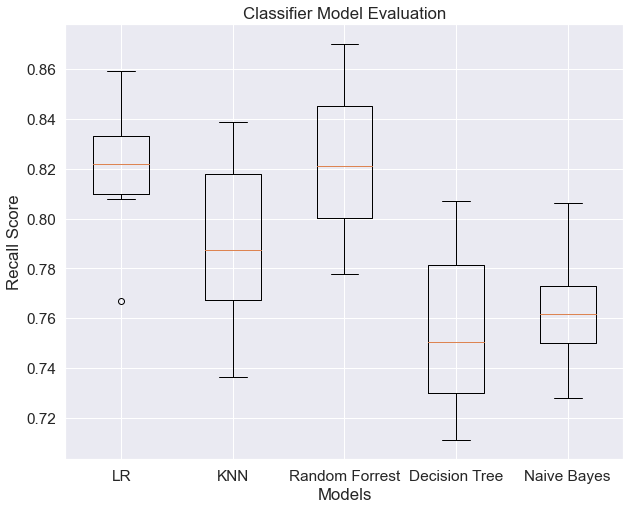

In [72]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Random Forrest', RandomForestClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
#models.append(('GBT', GradientBoostingClassifier()))
models.append(('Naive Bayes', GaussianNB()))

results = []
names = []
scoring = 'balanced_accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring=scoring)
    results.append(cv_results) #add results to list which will be displayed for each model
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) #format message
    print(msg)

plt.figure(figsize=(10, 8))
plt.boxplot(results)
plt.xlabel('Models')
plt.ylabel('Recall Score')
labels = names
labels_num = [1,2,3,4,5]
plt.xticks(labels_num, labels)
plt.title('Classifier Model Evaluation')
plt.savefig('model_selection.png')

We will further look into the application of the highest performing models for our dataset, which yield a relatively strong score. This is Random Forrest and Logistic Regression. For our machine learning process, we will utiliz Logistic Regression. We will then hypertune and apply our model to gain insight into our predictors' relationship with the target variable, treatment.

## Logistic Regression

### Base Model

In [73]:
clf = LogisticRegression()
scoring = {'balanced_accuracy': 'balanced_accuracy',
           'precision': 'precision_macro',
           'recall': 'recall_macro', 
           'f1': 'f1',
           'roc_auc': 'roc_auc'}

kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
cv_results = model_selection.cross_validate(clf, X_train, y_train.values.ravel(), cv=kfold, scoring=scoring)

In [74]:
scores=['test_balanced_accuracy', 'test_precision', 'test_recall', 
        'test_f1', 'test_roc_auc']
for score in scores:
    mean, std = round(cv_results[score].mean(), 4), round(cv_results[score].std(), 2)
    print('{}: mean={}, standard dev={}'.format(score, mean, std))

test_balanced_accuracy: mean=0.8196, standard dev=0.02
test_precision: mean=0.8206, standard dev=0.02
test_recall: mean=0.8196, standard dev=0.02
test_f1: mean=0.8215, standard dev=0.03
test_roc_auc: mean=0.8909, standard dev=0.01


These are the scores for our baseline Logistic Regression model with default parameters. The metric we want to focus on is **recall**. Recall calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative. **False Negatives in our analysis are employees who our model classifies as one who shouldn't seek treatment, when in actuality they should.** If this model is deployed to augment medical professionals' or business leaders' understanding of mental health for employees, missing these employees would be harmful. We would want efficiently catch and effectively not miss employees who are likely a hisk-risk candidate for mental health treatment; we would want to be able to help them right away.

Since this will be a robust evaluation pipeline for our model, we'll turn this into a few functions so we can easily fit different models for experimentation.

In [75]:
def cross_val_pipeline(X_data, y_data, classifier=LogisticRegression()):
    scoring = {'balanced_accuracy': 'balanced_accuracy',
           'precision': 'precision_macro',
           'recall': 'recall_macro', 
           'f1': 'f1',
           'roc_auc': 'roc_auc'}
    
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = model_selection.cross_validate(classifier, X_data, y_data.values.ravel(), 
                                            cv=kfold, scoring=scoring)
    
    scores=['test_balanced_accuracy', 'test_precision', 'test_recall', 
        'test_f1', 'test_roc_auc']
    
    score_dict = {}
    
    for score in scores:
        mean = round(cv_results[score].mean(), 4)
        score_dict[score] = mean
    
    return(score_dict)

### Random Search

In [76]:
#defining the search space
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

space = dict()
space['solver'] = ['saga', 'liblinear']
space['penalty'] = ['l1']
space['C'] = [0.001,.009,0.01,.09,1,5,10,25]

#defining the searcH
search = RandomizedSearchCV(clf, space, n_iter=500, scoring='balanced_accuracy', n_jobs=-1, cv=cv, random_state=1)

result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning:

The total space of parameters 16 is smaller than n_iter=500. Running 16 iterations. For exhaustive searches, use GridSearchCV.



Best Score: 0.8219727891156464
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Our random search has returned the best evaluated hyperparameters for our model, which we will then use to implement a final model from which we will gather insights.

Lasso regression has an advantage over ridge regression in that while ridge regression shrinks coefficients to zero, it can never fully diminish it to zero. Resultantly, all features will be included in the model despite how small the coefficients can become. On the other hand, **Lasso regression enables the shrinking of coefficients exactly to zero. This serves to be an intuitive feature selection tool.**

### Feature Selection: Recursive Feature Elimination

In [77]:
#Creating RFE Pipeline for Evaluation
def rfe_eval_pipeline(X_data, y_data, clf=LogisticRegression()):
    
    n_feature_space = np.arange(20,36,1)
    feature_score_dict = {}
    for n in n_feature_space:
        rfe = RFE(clf, n_features_to_select=n)
        rfe = rfe.fit(X_data, y_data.values.ravel())
        
        ranking = [i for i in range(len(rfe.ranking_)) if rfe.ranking_[i] < 2]
        X_rfe = pd.DataFrame()

        for index in ranking:
            col_name=X_data.columns[index]
            X_rfe[col_name]=X_data.iloc[:, index]
        
        clf=LogisticRegression()
        kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
        cv_results = model_selection.cross_validate(clf, X_rfe, y_data.values.ravel(), 
                                                    cv=kfold, scoring='recall_macro')
        feature_score_dict[str(n)] = round(cv_results['test_score'].mean(),4)
    
    return feature_score_dict

{'20': 0.8232, '21': 0.8245, '22': 0.8245, '23': 0.8234, '24': 0.8241, '25': 0.8229, '26': 0.8229, '27': 0.8238, '28': 0.8209, '29': 0.8223, '30': 0.8254, '31': 0.8208, '32': 0.8197, '33': 0.8219, '34': 0.8206, '35': 0.8196}


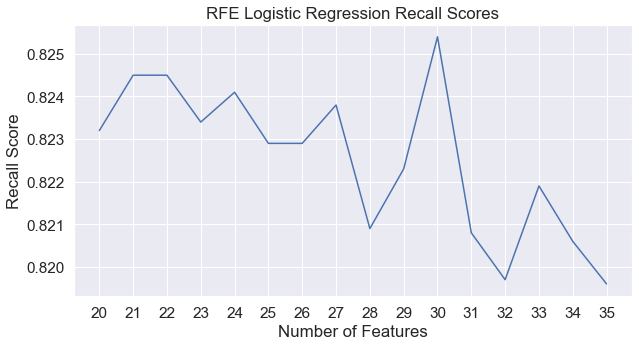

CPU times: user 17.5 s, sys: 3.14 s, total: 20.6 s
Wall time: 5.56 s


<Figure size 432x288 with 0 Axes>

In [78]:
%%time
rfe_results=rfe_eval_pipeline(X_train, y_train)
print(rfe_results)

lists = sorted(rfe_results.items()) # sorted by key, return a list of tuples
rfe_eval_x, rfe_eval_y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(10,5))
plt.title('RFE Logistic Regression Recall Scores')
plt.xlabel('Number of Features')
plt.ylabel('Recall Score')
plt.plot(rfe_eval_x, rfe_eval_y)
plt.show()
plt.savefig('rfe.png')

In [79]:
clf = LogisticRegression()
rfe = RFE(clf, n_features_to_select=30)
rfe = rfe.fit(X_train, y_train.values.ravel())

print(rfe.support_)
print(rfe.ranking_)

insignificant_pred = [i for i in range(len(rfe.ranking_)) if rfe.ranking_[i] > 1]

for ranking in insignificant_pred:
    insignificant_var = X_train.columns[ranking]
    print(insignificant_var)

[ True False False  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True False  True  True
  True  True  True  True  True  True  True False  True  True  True]
[1 4 6 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 5 1 1 1 1 1 1 1 1 1 3 1 1 1]
no_employees
leave
anonymity_No
phys_health_consequence_Yes
mental_vs_physical_Yes


In [80]:
#create new dataframe for RFE by removing insignificant variables
ranking = [i for i in range(len(rfe.ranking_)) if rfe.ranking_[i] < 2]
X_rfe = pd.DataFrame()
for index in ranking:
    col_name=X_train.columns[index]
    X_rfe[col_name]=X_train.iloc[:, index]

#evaulate score for this model
clf = LogisticRegression()
kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
cv_results = model_selection.cross_validate(clf, X_rfe, y_train.values.ravel(), 
                                                    cv=kfold, scoring='recall_macro')
print(cv_results['test_score'].mean())

0.8254362430981695


RFE allows us to effectively select features in a training dataset that are more or most relevant in predicting the target variable. What we interpret from the output is a list of rankings for our all our features used in the model. Ranking values greater than 1 become less and less significant in ascending order. We can use proceed with only using the features that were ranked as 1 to improve our model performance. However, we will automate the evaluation of the feature selection space to find the most appropriate number of features to use.

These results indicate that our metrics relatively decrease as more features are added, which makes sense. However there are some spikes within the scores. We will settle on the number of features to be 28 for now.

### Logistic Regression Model Implementation and Experimentation 

In [81]:
#recursive feature elimination logistic regression
rfe_logreg_score=cross_val_pipeline(X_rfe, y_train)
#default logistic regrssion
base_logreg_score=cross_val_pipeline(X_train, y_train)
#hyperparameter tuned logistic regression
hyper_logreg_score=cross_val_pipeline(X_train, y_train, LogisticRegression(solver='saga', C=0.09, penalty='l1'))
#recursive feature elimination + hyperparameters logistic regression
hyper_rfe_logreg_score=cross_val_pipeline(X_rfe, y_train, LogisticRegression(solver='saga', C=0.09, penalty='l1'))

#unpack cross validation scores into tuples
rfe_logreg_list = rfe_logreg_score.items()
rfe_x,rfe_y= zip(*rfe_logreg_list)

base_logreg_list = base_logreg_score.items()
base_x,base_y= zip(*base_logreg_list)

hyper_logreg_list = hyper_logreg_score.items()
hyper_x,hyper_y= zip(*hyper_logreg_list)

hyper_rfe_logreg_list = hyper_rfe_logreg_score.items()
hype_rfe_x,hype_rfe_y= zip(*hyper_rfe_logreg_list)

In [82]:
base_logreg_score

{'test_balanced_accuracy': 0.8196,
 'test_precision': 0.8206,
 'test_recall': 0.8196,
 'test_f1': 0.8215,
 'test_roc_auc': 0.8909}

In [83]:
hyper_logreg_score

{'test_balanced_accuracy': 0.8187,
 'test_precision': 0.8224,
 'test_recall': 0.8187,
 'test_f1': 0.8237,
 'test_roc_auc': 0.8876}

In [84]:
rfe_logreg_score

{'test_balanced_accuracy': 0.8254,
 'test_precision': 0.8268,
 'test_recall': 0.8254,
 'test_f1': 0.8279,
 'test_roc_auc': 0.8937}

In [85]:
hyper_rfe_logreg_score

{'test_balanced_accuracy': 0.8207,
 'test_precision': 0.825,
 'test_recall': 0.8207,
 'test_f1': 0.8259,
 'test_roc_auc': 0.8887}

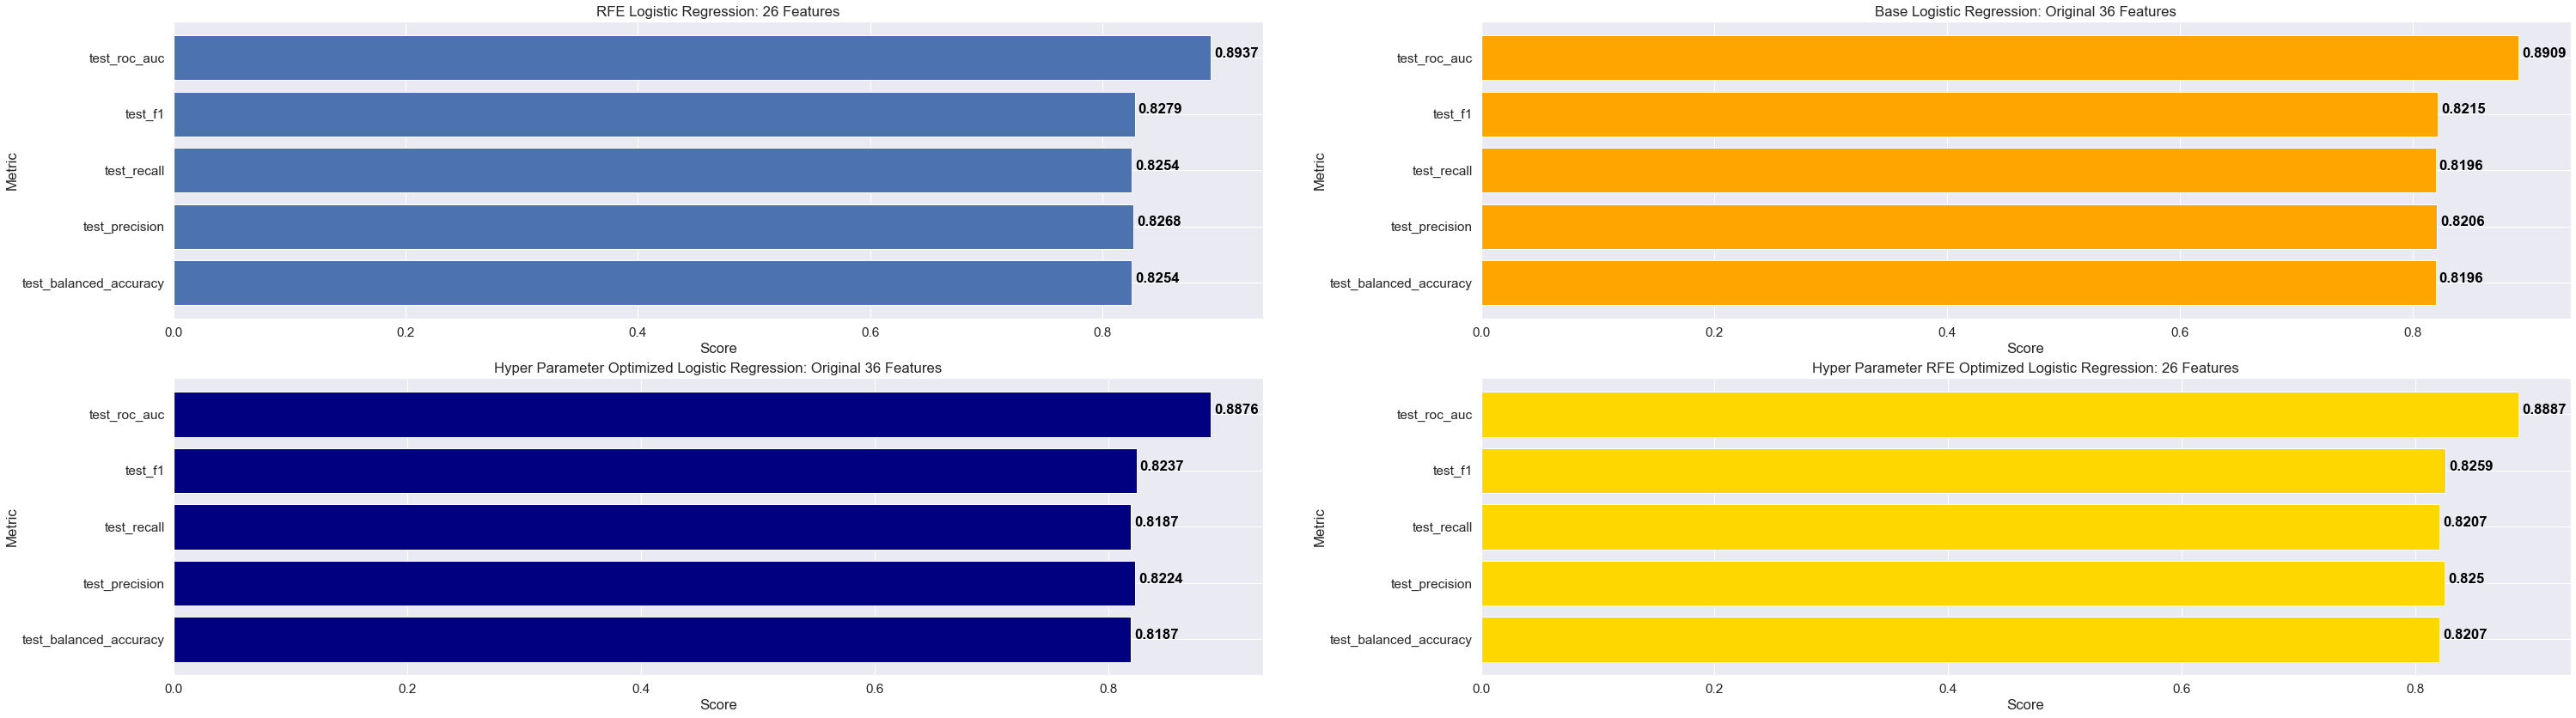

In [86]:
fig, ax = plt.subplots(2,2, figsize=(50,14))    

ax[0][0].barh(rfe_x,rfe_y)
ax[0][0].set(title='RFE Logistic Regression: 26 Features', ylabel='Metric', xlabel='Score')
for i, v in enumerate(rfe_y):
    ax[0][0].text(v + .003, i + .005, str(v), 
            color = 'black', fontweight='bold')
    
ax[0][1].barh(base_x, base_y, color= 'orange')
ax[0][1].set(title='Base Logistic Regression: Original 36 Features', ylabel='Metric', xlabel='Score')
for i, v in enumerate(base_y):
    ax[0][1].text(v + .003, i + .005, str(v), 
            color = 'black', fontweight='bold')
    
ax[1][0].barh(hyper_x, hyper_y, color= 'navy')
ax[1][0].set(title='Hyper Parameter Optimized Logistic Regression: Original 36 Features', 
          ylabel='Metric', xlabel='Score')
for i, v in enumerate(hyper_y):
    ax[1][0].text(v + .003, i + .005, str(v), 
            color = 'black', fontweight='bold')
    
ax[1][1].barh(hype_rfe_x, hype_rfe_y, color= 'gold')
ax[1][1].set(title='Hyper Parameter RFE Optimized Logistic Regression: 26 Features', 
          ylabel='Metric', xlabel='Score')
for i, v in enumerate(hype_rfe_y):
    ax[1][1].text(v + .003, i + .005, str(v), 
            color = 'black', fontweight='bold')
plt.savefig('all_models.png')

We see that the highest score is between the lower models where we conducted random search to find the optimal hyperparameters and where hyperparameter optimization was paired with recursive feature elimination. Since the two models are so similar in scores, we will choose the Logistic Regression with optimized hyperparameters only. For our use case, it is more practical in terms of interpretability. Moreover, we will want to interpret all the features later in our machine learning model insights -- which ones are significant and not to our predictability performance. 

### Confusion Matrix

In [87]:
drop_columns = []
for ranking in insignificant_pred:
    insignificant_var = X_train.columns[ranking]
    drop_columns.append(insignificant_var)
print(drop_columns)

['no_employees', 'leave', 'anonymity_No', 'phys_health_consequence_Yes', 'mental_vs_physical_Yes']


In [88]:
X_train=X_train.drop(drop_columns, axis=1)
X_test=X_test.drop(drop_columns, axis=1)

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       116
           1       0.84      0.83      0.84       131

    accuracy                           0.83       247
   macro avg       0.83      0.83      0.83       247
weighted avg       0.83      0.83      0.83       247



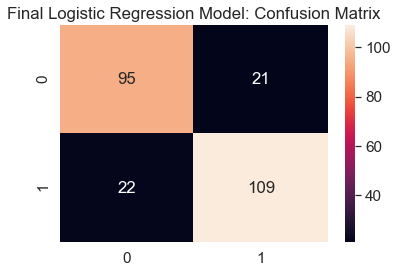

In [89]:
final_model=LogisticRegression()
final_model.fit(X_train, y_train.values.ravel())
pred_y = final_model.predict(X_test)
print(classification_report(y_test, pred_y))

plt.title('Final Logistic Regression Model: Confusion Matrix')
cm=confusion_matrix(y_test, pred_y)
sns.heatmap(cm, annot=True, fmt='g')

### Coefficient Interpretation

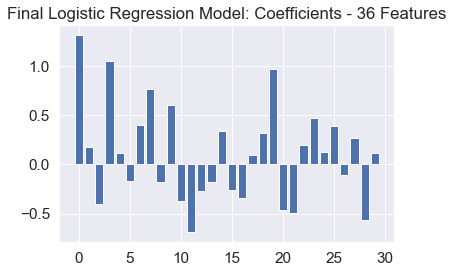

In [90]:
importance = final_model.coef_[0]
# plot feature importance
plt.title('Final Logistic Regression Model: Coefficients - 36 Features')
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [91]:
# summarize feature importance
feature_imp = {}
for i,v in enumerate(importance):
    feature_imp[i] = v
    
feature_imp_exp = { k : round(np.exp(v),4) for k,v in feature_imp.items() if abs(v) > 0}
feature_imp_exp_sorted = {k: v for k, v in sorted(feature_imp_exp.items(), key=lambda item: item[1])}
feature_imp_list = feature_imp_exp_sorted.items()
feature_x,feature_y= zip(*feature_imp_list)

for k, v in feature_imp_exp_sorted.items():
    print('Feature: {} | Coefficient {}'.format(X.columns[k], v))

Feature: care_options_Yes | Coefficient 0.5006
Feature: phys_health_interview_No | Coefficient 0.5694
Feature: phys_health_consequence_Yes | Coefficient 0.6082
Feature: phys_health_consequence_No | Coefficient 0.6267
Feature: leave | Coefficient 0.6698
Feature: care_options_Not sure | Coefficient 0.6901
Feature: anonymity_No | Coefficient 0.7078
Feature: wellness_program_No | Coefficient 0.7648
Feature: seek_help_Yes | Coefficient 0.7678
Feature: wellness_program_Yes | Coefficient 0.8329
Feature: benefits_No | Coefficient 0.8344
Feature: family_history_Yes | Coefficient 0.8458
Feature: mental_health_interview_No | Coefficient 0.8998
Feature: anonymity_Yes | Coefficient 1.1047
Feature: self_employed_Yes | Coefficient 1.1274
Feature: phys_health_interview_Yes | Coefficient 1.1288
Feature: supervisor_Some of them | Coefficient 1.1335
Feature: no_employees | Coefficient 1.1946
Feature: coworkers_Some of them | Coefficient 1.2238
Feature: mental_health_interview_Yes | Coefficient 1.3105
Fea

Our model performed very well with high scores for our metric, recall. However, there is more False Negatives than False Positives. Our goal was to minimize False Negatives as much as possible. Fortunately, our model was able to catch a lot of True Negatives.

### ROC Curve

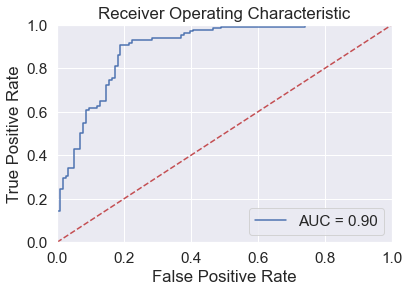

<Figure size 432x288 with 0 Axes>

In [92]:
probs = final_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig('ROC.png')

## Random Forrest

### Hyper Parameter Optimization: Grid Search

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Number of trees in random forest
n_estimators = [200, 650, 1550]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 50, 100, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [200, 650, 1550], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 50, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [94]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 50, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 650, 1550]},
                   random_state=42, verbose=2)

In [95]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50}

### Model Experimentation and Implementation

1. Base Random Forrest Model
2. Random Forrest with Hyper-parameter optimization and original 35 features

In [96]:
#base random forrest
rf_clf = RandomForestClassifier()
rf_clf_score=cross_val_pipeline(X_train, y_train, rf_clf)

#Random Forrest with Hyper-parameter optimization + original 35 features
rf_hp_clf = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=2, 
                               max_features='auto', max_depth=50)
rf_hp_clf_score=cross_val_pipeline(X_train, y_train, rf_hp_clf)

#unpack cross validation scores into tuples
rf_clf_score_list = rf_clf_score.items()
rf_x,rf_y= zip(*rf_clf_score_list)

rf_hp_clf_list = rf_hp_clf_score.items()
rf_hp_x,rf_hp_y= zip(*rf_hp_clf_list)

In [97]:
rf_clf_score

{'test_balanced_accuracy': 0.8271,
 'test_precision': 0.8314,
 'test_recall': 0.8271,
 'test_f1': 0.8311,
 'test_roc_auc': 0.892}

In [98]:
rf_hp_clf_score

{'test_balanced_accuracy': 0.821,
 'test_precision': 0.8263,
 'test_recall': 0.821,
 'test_f1': 0.8259,
 'test_roc_auc': 0.8952}

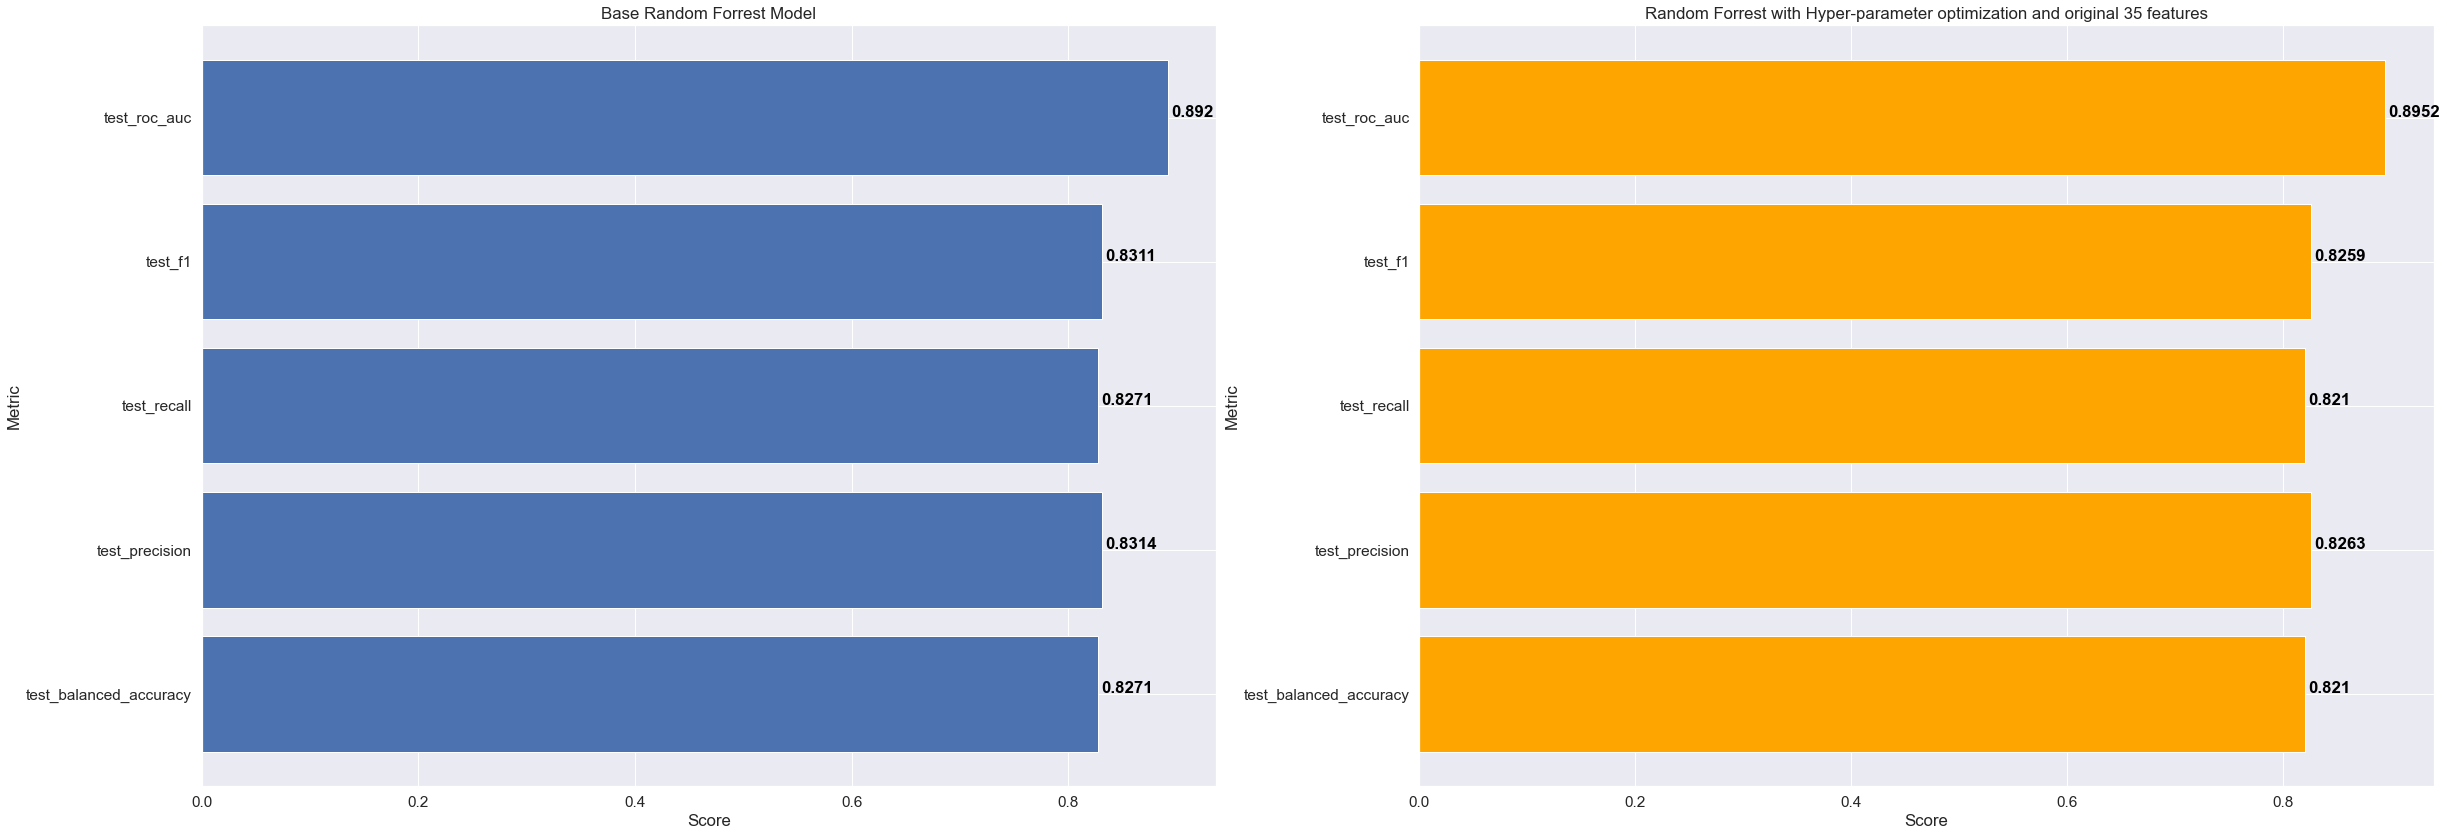

In [99]:
fig, ax = plt.subplots(1,2, figsize=(40,14))    

ax[0].barh(rf_x,rf_y)
ax[0].set(title='Base Random Forrest Model', ylabel='Metric', xlabel='Score')
for i, v in enumerate(rf_y):
    ax[0].text(v + .003, i + .005, str(v), 
            color = 'black', fontweight='bold')
    
ax[1].barh(rf_hp_x,rf_hp_y, color='orange')
ax[1].set(title='Random Forrest with Hyper-parameter optimization and original 35 features', 
          ylabel='Metric', xlabel='Score')
for i, v in enumerate(rf_hp_y):
    ax[1].text(v + .003, i + .005, str(v), 
            color = 'black', fontweight='bold')

### Confusion Matrix

In [100]:
final_rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=2, 
                               max_features='auto', max_depth=50)
final_rf_model.fit(X_train,y_train.values.ravel())

RandomForestClassifier(max_depth=50, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200)

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       116
           1       0.83      0.88      0.85       131

    accuracy                           0.84       247
   macro avg       0.84      0.84      0.84       247
weighted avg       0.84      0.84      0.84       247



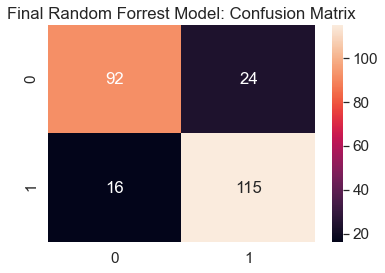

In [101]:
pred_y = final_rf_model.predict(X_test)
print(classification_report(y_test, pred_y))

plt.title('Final Random Forrest Model: Confusion Matrix')
cm=confusion_matrix(y_test, pred_y)
sns.heatmap(cm, annot=True, fmt='g')

### Feature Importance

In [102]:
rf_fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': final_rf_model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
rf_fi.head(10)

feature  importance
0                 work_interfere    0.411564
5             family_history_Yes    0.096729
1                   no_employees    0.039610
11              care_options_Yes    0.039155
2                          leave    0.036998
9                   benefits_Yes    0.028872
33                   Gender_male    0.021020
3                      Age_range    0.019794
22        coworkers_Some of them    0.018251
18  mental_health_consequence_No    0.017083

## Without work_interfere

              precision    recall  f1-score   support

           0       0.70      0.69      0.70       116
           1       0.73      0.74      0.73       131

    accuracy                           0.72       247
   macro avg       0.72      0.72      0.72       247
weighted avg       0.72      0.72      0.72       247



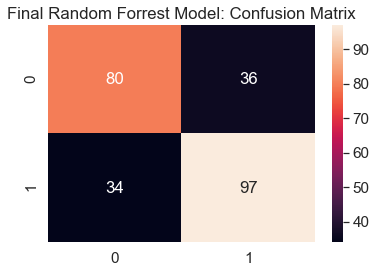

In [103]:
X = X.drop('work_interfere', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

wi_rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=2, 
                               max_features='auto', max_depth=50)
wi_rf_model.fit(X_train,y_train.values.ravel())

pred_y = wi_rf_model.predict(X_test)
print(classification_report(y_test, pred_y))

plt.title('Final Random Forrest Model: Confusion Matrix')
cm=confusion_matrix(y_test, pred_y)
sns.heatmap(cm, annot=True, fmt='g')